In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [53]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
year_precipitation = session.query(*sel).filter(Measurement.date > '2016-08-23').all()
year_precipitation
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_precipitation, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df.dropna(subset = ["prcp"], inplace=True)
# Sort the dataframe by date
df.sort_index()

,prcp
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


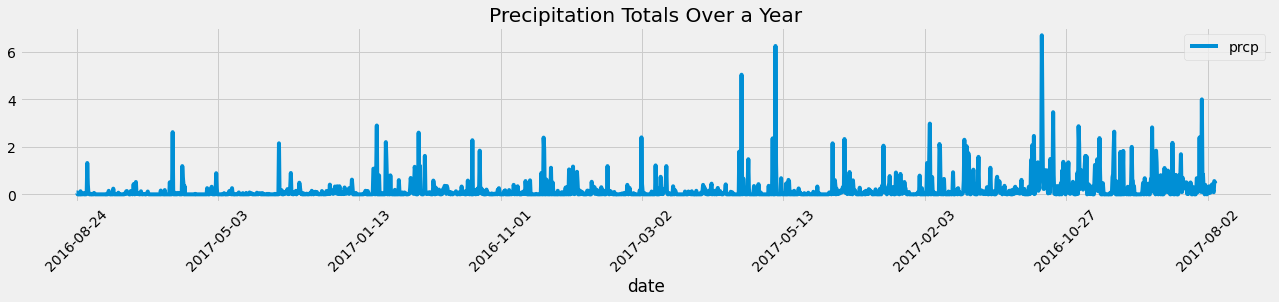

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="line", figsize=(20,3))
plt.title("Precipitation Totals Over a Year")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = df.groupby(["date"]).agg({"prcp":["mean", "median", "var", "std", "sem"]})
summary

prcp                                     
                mean median       var       std       sem
date                                                     
2016-08-24  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27  0.064000  0.020  0.006680  0.081731  0.036551
2016-08-28  0.516667  0.140  0.620427  0.787672  0.321566
...              ...    ...       ...       ...       ...
2017-08-19  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23  0.132500  0.040  0.046225  0.215000  0.107500

[365 rows x 5 columns]

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station).group_by(Station.station).count()
number_stations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?

# USC00519281 has the most active stations

# List the stations and the counts in descending order.
session.query((Measurement.station), func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(lowest_temp)
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(highest_temp)
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(average_temp)

[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


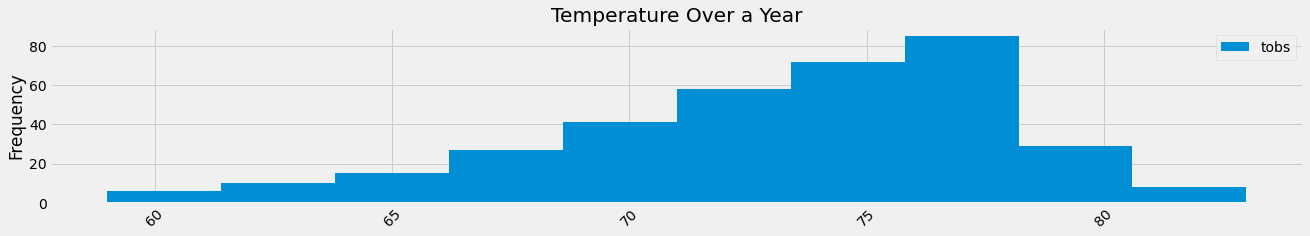

In [38]:
# Choose the station with the highest number of temperature observations.
session.query((Measurement.station), func.count(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]
year_temp = session.query(*sel).filter(Measurement.date > '2016-08-23').filter(Measurement.station == 'USC00519281').all()
df_temp = pd.DataFrame(year_temp, columns=['date', 'tobs'])
df_temp.set_index('date', inplace=True)
df_temp.dropna(subset = ["tobs"], inplace=True)

# Sort the dataframe by date
df_temp.sort_index()
df_temp.plot(kind="hist", figsize=(20,3))
plt.title("Temperature Over a Year")
plt.xticks(rotation=45)
plt.show()

## Bonus Challenge Assignment

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
Trip = calc_temps('2016-12-20', '2017-01-02')
Trip

[(62.0, 71.81818181818181, 78.0)]

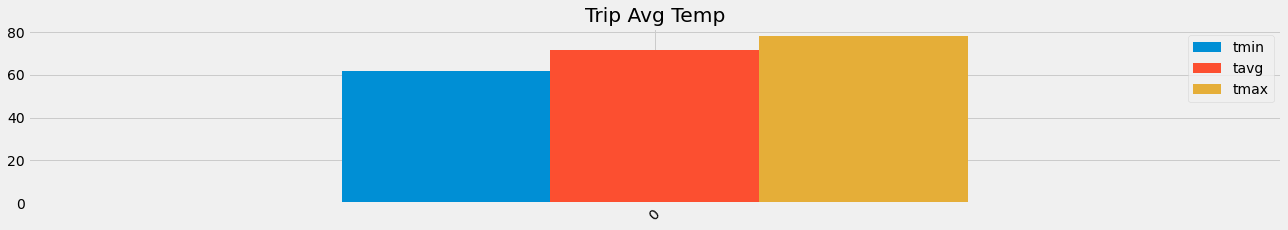

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df_trip = pd.DataFrame(Trip, columns=['tmin', 'tavg', 'tmax'])

df_trip.plot(kind="bar", figsize=(20,3))
plt.title("Trip Avg Temp")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [51]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
